In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertModel
import torch
from joblib import dump

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
data = pd.read_csv(r'BIAS_DATASET.csv')

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEXT    1103 non-null   object
 1   TARGET  1102 non-null   object
 2   LABEL   1103 non-null   object
dtypes: object(3)
memory usage: 26.0+ KB
None


In [4]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
TEXT      0
TARGET    1
LABEL     0
dtype: int64


In [5]:
# Drop rows with missing values
data = data.dropna()

# Check for and drop duplicate rows
data = data.drop_duplicates()

In [11]:
# Visualize the distribution of the labels
def visualization(data):
    label_counts = data.value_counts()
    colors = ['orange', 'green', 'red', 'blue']
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color=colors)
    plt.title('Distribution of Categories in the LABEL Column')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


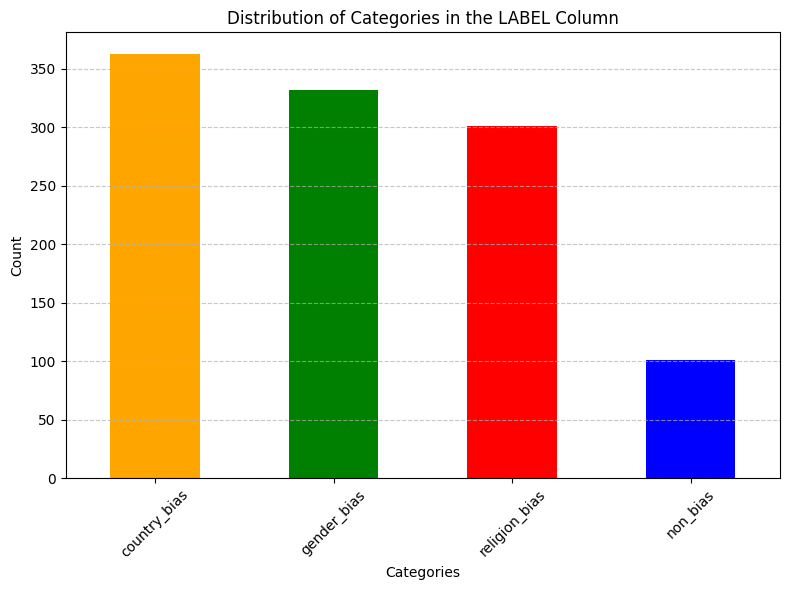

In [12]:
visualization(data['LABEL'])

In [8]:
#download the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [9]:
def tokenize_and_extract_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [10]:
# Apply the BERT embedding function to each text entry
print("Extracting BERT embeddings...")
data['embeddings'] = data['TEXT'].apply(tokenize_and_extract_embeddings)

Extracting BERT embeddings...


In [13]:
# Convert embeddings and labels to numpy arrays
X = np.vstack(data['embeddings'].values)
y = data['LABEL'].values

In [14]:
# Apply SMOTE to balance the dataset
print("Applying SMOTE...")
smote = SMOTE(sampling_strategy={'non_bias': 350, 'country_bias': 364, 'gender_bias': 337, 'religion_bias': 301}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Applying SMOTE...


In [15]:
y_sampled = pd.Series(y_resampled)

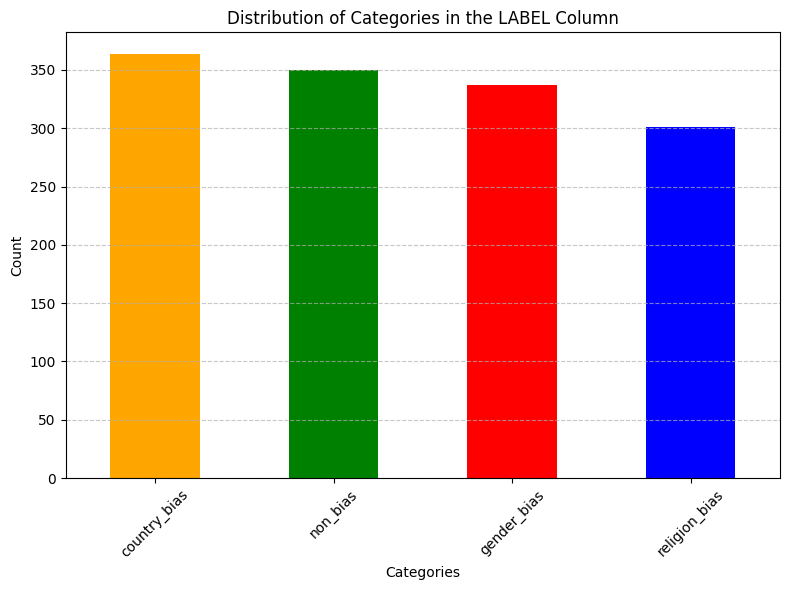

In [16]:
visualization(y_sampled)

In [ ]:
# # Visualize the distribution of the labels after SMOTE
# resampled_label_counts = pd.Series(y_resampled).value_counts()
# print(resampled_label_counts)
# plt.figure(figsize=(8, 6))
# resampled_label_counts.plot(kind='bar', color=colors)
# plt.title('Distribution of Categories in the LABEL Column After SMOTE')
# plt.xlabel('Categories')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [17]:
# Train-test split
print("Performing train-test split...")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Performing train-test split...


In [18]:
# Initialize and train classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'MLP': MLPClassifier(max_iter=1000, random_state=42)
}

In [19]:
# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Results for {name}:")
    dump(clf, f'{name}.pkl')
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

Training Logistic Regression...
Results for Logistic Regression:
               precision    recall  f1-score   support

 country_bias       0.81      0.80      0.80        83
  gender_bias       0.85      0.89      0.87        63
     non_bias       1.00      1.00      1.00        69
religion_bias       0.78      0.77      0.77        56

     accuracy                           0.86       271
    macro avg       0.86      0.86      0.86       271
 weighted avg       0.86      0.86      0.86       271



Training Decision Tree...
Results for Decision Tree:
               precision    recall  f1-score   support

 country_bias       0.61      0.57      0.59        83
  gender_bias       0.58      0.67      0.62        63
     non_bias       0.93      0.90      0.91        69
religion_bias       0.49      0.48      0.49        56

     accuracy                           0.66       271
    macro avg       0.65      0.65      0.65       271
 weighted avg       0.66      0.66      0.66      